In [ ]:
# Importing Libraries
import numpy as np
from cv2 import dct, idct
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
import os
from collections import Counter, defaultdict
import heapq
import pandas as pd

In [ ]:
# Function to view Greyscale image
def view_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()

# Function to view Y Cr and Cb channels of an image
def view_ycrcb_image(y, cr, cb, title):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(y, cmap = 'gray')
    ax[0].set_title('Y')
    ax[1].imshow(cr, cmap = 'gray')
    ax[1].set_title('Cr')
    ax[2].imshow(cb, cmap = 'gray')
    ax[2].set_title('Cb')

    fig.suptitle(title)
    plt.show()

# Function to get ssim for a colour image
def get_ssim_colour(image1, image2):
    y1, cr1, cb1 = cv2.split(cv2.cvtColor(image1, cv2.COLOR_BGR2YCrCb))
    y2, cr2, cb2 = cv2.split(cv2.cvtColor(image2, cv2.COLOR_BGR2YCrCb))

    y1_np = np.array(y1)
    cr1_np = np.array(cr1)
    cb1_np = np.array(cb1)

    y2_np = np.array(y2)
    cr2_np = np.array(cr2)
    cb2_np = np.array(cb2)

    ssim_y = ssim(y1_np, y2_np, data_range=y2_np.max() - y2_np.min())
    ssim_cr = ssim(cr1_np, cr2_np, data_range=cr2_np.max() - cr2_np.min())
    ssim_cb = ssim(cb1_np, cb2_np, data_range=cb2_np.max() - cb2_np.min())

    return np.mean([ssim_y, ssim_cr, ssim_cb])

In [ ]:
# Functions to convert integers to binary strings of required length
def bin4(x):
    if x >= 0:
        return format(x, '04b')
    else:
        return format((1 << 4) + x, '04b')


def bin8(x):   
    if x >= 0:
        return format(x, '08b')
    else:
        return format((1 << 8) + x, '08b')
    
def bin16(x):
    if x >= 0:
        return format(x, '016b')
    else:
        return format((1 << 16) + x, '016b')
    
def bin12(x):
    if x >= 0:
        return format(x, '012b')
    else:
        return format((1 << 12) + x, '012b')

In [5]:
# Define a helper class to build the Huffman tree
class HuffmanNode:
    def __init__(self, value, freq):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Function to build the Huffman tree
def build_huffman_tree(frequency):
    heap = [HuffmanNode(value, freq) for value, freq in frequency.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        
        heapq.heappush(heap, merged)
    
    return heap[0]  # Root of the Huffman tree

# Function to generate Huffman codes
def generate_huffman_codes(root):
    huffman_codes = {}
    
    def generate_codes(node, current_code=""):
        if node is None:
            return
        if node.value is not None:
            huffman_codes[node.value] = current_code
            return
        generate_codes(node.left, current_code + "0")
        generate_codes(node.right, current_code + "1")
    
    generate_codes(root)
    return huffman_codes

In [ ]:
# Encoding function with RLE and Huffman encoding
class Encoder:
    def encode(self, rle_img):
        # Extract values for Huffman encoding
        values = [val for count, val in rle_img]
        
        # Build Huffman Tree
        frequency = Counter(values)
        huffman_tree = build_huffman_tree(frequency)
        huffman_codes = generate_huffman_codes(huffman_tree)

        # Encode RLE data with Huffman codes
        encoded_huffman = ""
        non_encoded = ""    # Not used in this case
        for run, val in rle_img:
            # Convert run to binary
            while run>15:
                encoded_huffman += '1111' + bin8(len(huffman_codes[0])) + huffman_codes[0] 
                run -= 16
            binary_run = bin4(run)
            huffman_len = bin8(len(huffman_codes[val]))
            encoded_huffman += binary_run + huffman_len + huffman_codes[val]
        
        return encoded_huffman, huffman_codes, non_encoded

In [ ]:
def decode_huffman(binary_data):
    # Convert data to 0s and 1s
    binary_data = ''.join(format(byte, '08b') for byte in binary_data)
    # Read the quality factor
    qf = int(binary_data[:8], 2)
    binary_data = binary_data[8:]

    # ---------------------------- Y --------------------------------
    # Read the length of huffman codes data 
    length_huffman_Y = int(binary_data[:32], 2) * 8
    binary_data = binary_data[32:]
    skip_head1_Y = int(binary_data[:8], 2)
    binary_data = binary_data[8:]
    binary_data = binary_data[skip_head1_Y:]

    # Read the huffman codes
    huffman_codes_Y = {}
    while length_huffman_Y - skip_head1_Y > 0:
        key = int(binary_data[:12], 2)
        if key > 2047:
            key = key - 4096
        binary_data = binary_data[12:]
        length = int(binary_data[:8], 2)
        binary_data = binary_data[8:]
        huffman_codes_Y[key] = binary_data[:length]
        binary_data = binary_data[length:]
        length_huffman_Y -= (20 + length)  

    # Read the huffman encoded data 
    len_bin_data_Y = int(binary_data[:32], 2) * 8
    binary_data = binary_data[32:]
    skip_head2_Y = int(binary_data[:8], 2)
    binary_data = binary_data[8:]
    binary_data = binary_data[skip_head2_Y:]
    decoded_Y = ""
    code = ""
    # huffman encoded data is in the form (run_length (4 bits), length of huffman (4 bits) , huffman code)
    # run_length is the number of zeros before the huffman code
    i = 0
    while len_bin_data_Y - skip_head2_Y > i:
        run = int(binary_data[i:i+4], 2)
        length = int(binary_data[i+4:i+12], 2)
        code = binary_data[i+12:i+12+length]

        if len(code) > 0:
            value = [key for key, value in huffman_codes_Y.items() if value == code][0]
        else:
            value = 0
        decoded_Y += str(run) + ' ' + str(value) + ' '
        i += 12 + length

    binary_data = binary_data[len_bin_data_Y - skip_head2_Y:]

    # ---------------------------- Cb --------------------------------
    length_huffman_Cb = int(binary_data[:32], 2) * 8
    binary_data = binary_data[32:]
    skip_head1_Cb = int(binary_data[:8], 2)
    binary_data = binary_data[8:]
    binary_data = binary_data[skip_head1_Cb:]
    huffman_codes_Cb = {}
    while length_huffman_Cb - skip_head1_Cb > 0:
        key = int(binary_data[:12], 2)
        if key > 2047:
            key = key - 4096
        binary_data = binary_data[12:]
        length = int(binary_data[:8], 2)
        binary_data = binary_data[8:]
        huffman_codes_Cb[key] = binary_data[:length]
        binary_data = binary_data[length:]
        length_huffman_Cb -= (20 + length)

    # print('huffman_codes_Cb', huffman_codes_Cb)
    len_bin_data_Cb = int(binary_data[:32], 2) * 8
    binary_data = binary_data[32:]
    skip_head2_Cb = int(binary_data[:8], 2)
    binary_data = binary_data[8:]
    binary_data = binary_data[skip_head2_Cb:]
    decoded_Cb = ""
    code = ""
    i = 0
    while len_bin_data_Cb - skip_head2_Cb > i:
        run = int(binary_data[i:i+4], 2)
        length = int(binary_data[i+4:i+12], 2)
        code = binary_data[i+12:i+12+length]
        if len(code) > 0:
            value = [key for key, value in huffman_codes_Cb.items() if value == code][0]
        else:
            value = 0
        decoded_Cb += str(run) + ' ' + str(value) + ' '
        i += 12 + length

    binary_data = binary_data[len_bin_data_Cb - skip_head2_Cb:]
    # ---------------------------- Cr --------------------------------
    length_huffman_Cr = int(binary_data[:32], 2) * 8
    binary_data = binary_data[32:]
    skip_head1_Cr = int(binary_data[:8], 2)
    binary_data = binary_data[8:]
    binary_data = binary_data[skip_head1_Cr:]
    huffman_codes_Cr = {}
    while length_huffman_Cr - skip_head1_Cr > 0:
        key = int(binary_data[:12], 2)
        if key > 2047:
            key = key - 4096
        binary_data = binary_data[12:]
        length = int(binary_data[:8], 2)
        binary_data = binary_data[8:]
        huffman_codes_Cr[key] = binary_data[:length]
        binary_data = binary_data[length:]
        length_huffman_Cr -= (20 + length)
    len_bin_data_Cr = int(binary_data[:32], 2) * 8
    binary_data = binary_data[32:]
    skip_head2_Cr = int(binary_data[:8], 2)
    binary_data = binary_data[8:]
    binary_data = binary_data[skip_head2_Cr:]
    decoded_Cr = ""
    code = ""
    i = 0
    while len_bin_data_Cr - skip_head2_Cr > i:
        run = int(binary_data[i:i+4], 2)
        length = int(binary_data[i+4:i+12], 2)
        code = binary_data[i+12:i+12+length]
        if len(code) > 0:
            value = [key for key, value in huffman_codes_Cr.items() if value == code][0]
        else:
            value = 0
        decoded_Cr += str(run) + ' ' + str(value) + ' '
        i += 12 + length

    return qf, decoded_Y, huffman_codes_Y, decoded_Cb, huffman_codes_Cb, decoded_Cr, huffman_codes_Cr

In [8]:
def pair_numbers(string):
    # Split the string by spaces and convert each part to an integer
    numbers = list(map(int, string.split()))
    
    # Use list comprehension to group numbers into pairs of two
    pairs = [(numbers[i], numbers[i + 1]) for i in range(0, len(numbers), 2)]
    
    return pairs

In [9]:
# Reverse zig zag order
# Input is list of length 64, output is 8x8 matrix
def zigzag_unflatten(flat_list, rows, cols):
    # Initialize an empty matrix
    matrix = np.zeros((rows, cols), dtype=int)
    index = 0

    for s in range(rows + cols - 1):
        if s % 2 == 0:
            # Go upward-right
            r = min(s, rows - 1)
            c = s - r
            while r >= 0 and c < cols:
                matrix[r, c] = flat_list[index]
                index += 1
                r -= 1
                c += 1
        else:
            # Go downward-left
            c = min(s, cols - 1)
            r = s - c
            while c >= 0 and r < rows:
                matrix[r, c] = flat_list[index]
                index += 1
                r += 1
                c -= 1

    return matrix

In [ ]:
def decode_from_rle(decoded_Y, decoded_Cb, decoded_Cr, qf):
    quantizer_Y = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                              [12, 12, 14, 19, 26, 58, 60, 55],
                              [14, 13, 16, 24, 40, 57, 69, 56],
                              [14, 17, 22, 29, 51, 87, 80, 62],
                              [18, 22, 37, 56, 68, 109, 103, 77],
                              [24, 35, 55, 64, 81, 104, 113, 92],
                              [49, 64, 78, 87, 103, 121, 120, 101],
                              [72, 92, 95, 98, 112, 100, 103, 99]])     # Luminescence quantization matrix
    quantizer_Y = quantizer_Y * (50/qf)

    quantizer_Cb = np.array([[10, 8, 9, 9, 9, 8, 10, 9],
                                [9, 9, 10, 10, 10, 11, 12, 17],
                                [13, 12, 12, 12, 12, 20, 16, 16],
                                [14, 17, 18, 20, 23, 23, 22, 20],
                                [25, 25, 25, 25, 25, 25, 25, 25],
                                [25, 25, 25, 25, 25, 25, 25, 25],
                                [25, 25, 25, 25, 25, 25, 25, 25],
                                [25, 25, 25, 25, 25, 25, 25, 25]])   # Chrominance quantization matrix

    quantizer_Cb = quantizer_Cb * (50/qf)
    # Decode block by block

    pairs_Y = pair_numbers(decoded_Y)
    pairs_Cb = pair_numbers(decoded_Cb)
    pairs_Cr = pair_numbers(decoded_Cr)
    # Now we have the run-length encoded data in the form (run_length, value)
    # each block is separated by (0, 0)
    # Each block is 8x8
    # First get a flattened version of all the blocks
    blocks_Y = []
    block = []
    prev_dc = 0     
    total_entries = 0
    for run, value in pairs_Y:
        if run == 0 and value == 0:
            number_zeros = 64 - total_entries
            block += [0] * number_zeros
            block[0] += prev_dc
            prev_dc = block[0]
            blocks_Y.append(block)
            block = []
            total_entries = 0
        else:
            block += [0] * run + [value]
            total_entries += run + 1

    blocks_Cb = []
    block = []
    prev_dc = 0
    total_entries = 0
    for run, value in pairs_Cb:
        if run == 0 and value == 0:
            number_zeros = 64 - total_entries
            block += [0] * number_zeros
            block[0] += prev_dc
            prev_dc = block[0]
            blocks_Cb.append(block)
            block = []
            total_entries = 0
        else:
            block += [0] * run + [value]
            total_entries += run + 1

    blocks_Cr = []
    block = []
    prev_dc = 0
    total_entries = 0
    for run, value in pairs_Cr:
        if run == 0 and value == 0:
            number_zeros = 64 - total_entries
            block += [0] * number_zeros
            block[0] += prev_dc
            prev_dc = block[0]
            blocks_Cr.append(block)
            block = []
            total_entries = 0
        else:
            block += [0] * run + [value]
            total_entries += run + 1

    return blocks_Y, blocks_Cb, blocks_Cr, quantizer_Y, quantizer_Cb


In [ ]:
# Apply rev zig zag and dequantize
def dequantize_Y(blocks, quantizer):
    decoded_blocks = []
    for block in blocks:
        block = zigzag_unflatten(block, 8, 8)
        decoded_blocks.append(block * quantizer)

    # Apply inverse DCT
    decoded_image = np.zeros((512, 512))
    for i in range(0, 512, 8):
        for j in range(0, 512, 8):
            decoded_image[i:i+8, j:j+8] = idct(np.float32(decoded_blocks[i//8*64 + j//8])) + 128
            decoded_image[i:i+8, j:j+8] = np.clip(decoded_image[i:i+8, j:j+8], 0, 255)
    decoded_image = np.uint8(decoded_image)
    return decoded_image

In [12]:
def dequantize_Cb_Cr(blocks, quantizer):
    decoded_blocks = []
    for block in blocks:
        block = zigzag_unflatten(block, 8, 8)
        decoded_blocks.append(block * quantizer)

    # Apply inverse DCT
    decoded_image = np.zeros((256, 256))
    for i in range(0, 256, 8):
        for j in range(0, 256, 8):
            decoded_image[i:i+8, j:j+8] = idct(np.float32(decoded_blocks[i//8*32 + j//8])) + 128
            decoded_image[i:i+8, j:j+8] = np.clip(decoded_image[i:i+8, j:j+8], 0, 255)
    decoded_image = np.uint8(decoded_image)

    upsampled_image = cv2.resize(decoded_image, (512, 512), interpolation=cv2.INTER_LINEAR)
    upsampled_image = np.uint8(upsampled_image)
    return upsampled_image

In [13]:
class Decoder:
    def decode(self, binary_data):
        qf, decoded_Y, _, decoded_Cb, _, decoded_Cr, _ = decode_huffman(binary_data)
        blocks_Y, blocks_Cb, blocks_Cr, quantizer_Y, quantizer_Cb = decode_from_rle(decoded_Y, decoded_Cb, decoded_Cr, qf)
        decoded_Y = dequantize_Y(blocks_Y, quantizer_Y)
        decoded_Cb = dequantize_Cb_Cr(blocks_Cb, quantizer_Cb)
        decoded_Cr = dequantize_Cb_Cr(blocks_Cr, quantizer_Cb)
        return decoded_Y, decoded_Cb, decoded_Cr

In [ ]:
class ColourJPEG(Decoder):

    def __init__(self, filename, path, quality):
        self.originalImage = cv2.imread(path + filename)
        self.filename = filename    
        self.path = path
        self.originalImage = cv2.cvtColor(self.originalImage, cv2.COLOR_BGR2RGB)
        self.quality = quality
        
        self.luminaceQuantizer = (50 / self.quality) * np.array([
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])
        
        self.chrominanceQuantizer = (50 / self.quality) * np.array([
            [10, 8, 9, 9, 9, 8, 10, 9],
            [9, 9, 10, 10, 10, 11, 12, 17],
            [13, 12, 12, 12, 12, 20, 16, 16],
            [14, 17, 18, 20, 23, 23, 22, 20],
            [25, 25, 25, 25, 25, 25, 25, 25],
            [25, 25, 25, 25, 25, 25, 25, 25],
            [25, 25, 25, 25, 25, 25, 25, 25],
            [25, 25, 25, 25, 25, 25, 25, 25]])

    def get_ycrcb(self):
        self.imageY, self.imageCr, self.imageCb = cv2.split(cv2.cvtColor(self.originalImage, cv2.COLOR_RGB2YCrCb))  # Split the image into Y, Cr, Cb channels

    def downsampling(self):
        # Downsample Cb and Cr by a factor of 2 by averaging 2x2 blocks
        self.imageCb = cv2.resize(self.imageCb, (self.imageCb.shape[1] // 2, self.imageCb.shape[0] // 2), interpolation=cv2.INTER_AREA)
        self.imageCr = cv2.resize(self.imageCr, (self.imageCr.shape[1] // 2, self.imageCr.shape[0] // 2), interpolation=cv2.INTER_AREA)
        
    def colorDCT(self):
        # Perform block-wise DCT
        self.Ydct = np.zeros_like(self.imageY, dtype=np.float32)
        self.Cbdct = np.zeros_like(self.imageCb, dtype=np.float32)
        self.Crdct = np.zeros_like(self.imageCr, dtype=np.float32)

        for i in range(0, self.imageY.shape[0], 8):
            for j in range(0, self.imageY.shape[1], 8):
                self.Ydct[i:i+8, j:j+8] = dct(self.imageY[i:i+8, j:j+8].astype(np.float32) - 128)

        for i in range(0, self.imageCb.shape[0], 8):
            for j in range(0, self.imageCb.shape[1], 8):
                self.Cbdct[i:i+8, j:j+8] = dct(self.imageCb[i:i+8, j:j+8].astype(np.float32) - 128)
                self.Crdct[i:i+8, j:j+8] = dct(self.imageCr[i:i+8, j:j+8].astype(np.float32) - 128)

    def quantize(self):
        
        self.Yquantized = np.zeros_like(self.Ydct)  
        self.Cbquantized = np.zeros_like(self.Cbdct)    
        self.Crquantized = np.zeros_like(self.Crdct)        

        for i in range(0, self.imageY.shape[0], 8):
            for j in range(0, self.imageY.shape[1], 8):
                self.Yquantized[i:i+8, j:j+8] = np.round(self.Ydct[i:i+8, j:j+8] / self.luminaceQuantizer)      # Quantize the DCT coefficients for Y channel

        for i in range(0, self.imageCb.shape[0], 8):
            for j in range(0, self.imageCb.shape[1], 8):
                self.Cbquantized[i:i+8, j:j+8] = np.round(self.Cbdct[i:i+8, j:j+8] / self.chrominanceQuantizer) # Quantize the DCT coefficients for Cb channel
                self.Crquantized[i:i+8, j:j+8] = np.round(self.Crdct[i:i+8, j:j+8] / self.chrominanceQuantizer) # Quantize the DCT coefficients for Cr channel

    def zigzag_flatten(self, matrix):
        rows, cols = matrix.shape
        result = []
        
        for s in range(rows + cols - 1):
            if s % 2 == 0:
                # Go upward-right
                r = min(s, rows - 1)
                c = s - r
                while r >= 0 and c < cols:
                    result.append(matrix[r, c])
                    r -= 1
                    c += 1
            else:
                # Go downward-left
                c = min(s, cols - 1)
                r = s - c
                while c >= 0 and r < rows:
                    result.append(matrix[r, c])
                    r += 1
                    c -= 1           
        return result
    
    def rle_encode(self, image):
        rle = []
        prev_dc = 0 # Previous DC coefficient
        for i in range(0, image.shape[0], 8):
            for j in range(0, image.shape[1], 8):
                block = image[i:i+8, j:j+8]
                block_flatten = self.zigzag_flatten(block)  # Flatten the block in zig-zag order
                block_flatten[0] -= prev_dc # DC coefficient
                prev_dc = block_flatten[0] + prev_dc    # Update previous DC coefficient
                block_flatten = np.trim_zeros(block_flatten, 'b')   # Remove trailing zeros

                # RLE
                count = 0
                for value in block_flatten:
                    if value == 0:
                        count += 1  # Count the number of zeros
                    else:
                        rle.append((count, value))  # Add the run-length and value to the RLE
                        count = 0

                rle.append((0, 0))  # End of block

        return rle

    def encode(self):
        encoder = Encoder()
        rle_img_Y = self.rle_encode(self.Yquantized)
        self.encoded_Y, self.huffman_codes_Y, self.non_encoded_Y = encoder.encode(rle_img_Y)
        rle_img_Cb = self.rle_encode(self.Cbquantized)
        self.encoded_Cb, self.huffman_codes_Cb, self.non_encoded_Cb = encoder.encode(rle_img_Cb)
        rle_img_Cr = self.rle_encode(self.Crquantized)
        self.encoded_Cr, self.huffman_codes_Cr, self.non_encoded_Cr = encoder.encode(rle_img_Cr)

    def compress(self):
        self.get_ycrcb()
        self.downsampling()
        self.colorDCT()
        self.quantize()
        self.encode()

    def save_data(self):
    
        binary_huffman_codes_Y = ''
        binary_huffman_cb = ''
        binary_huffman_cr = ''

        #Quality Factor
        binary_qf = bin8(self.quality)
        binary_qf = int(binary_qf, 2).to_bytes((len(binary_qf) + 7) // 8, byteorder='big')

        #Y
        for key, value in self.huffman_codes_Y.items():
            binary_huffman_codes_Y += bin12(int(key)) + bin8(len(value)) + value 
        binary_huffman_data_Y = int(binary_huffman_codes_Y, 2).to_bytes((len(binary_huffman_codes_Y) + 7) // 8, byteorder='big')
        len_huffman_data_Y = len(binary_huffman_data_Y).to_bytes(4, byteorder='big')
        skip_head1_Y = (len(binary_huffman_data_Y)*8 - len(binary_huffman_codes_Y))% 8
        binary_sh1_Y = int(bin8(skip_head1_Y),2).to_bytes(1, byteorder='big')
        binary_data_Y = int(self.encoded_Y, 2).to_bytes((len(self.encoded_Y) + 7) // 8, byteorder='big')
        len_data_Y = len(binary_data_Y).to_bytes(4, byteorder='big')
        skip_head2_Y = (len(binary_data_Y)*8 - len(self.encoded_Y)) % 8
        binary_sh2_Y = int(bin8(skip_head2_Y),2).to_bytes(1, byteorder='big')

        #Cb
        for key, value in self.huffman_codes_Cb.items():
            binary_huffman_cb += bin12(int(key)) + bin8(len(value)) + value
        binary_huffman_data_Cb = int(binary_huffman_cb, 2).to_bytes((len(binary_huffman_cb) + 7) // 8, byteorder='big')
        len_huffman_data_Cb = len(binary_huffman_data_Cb).to_bytes(4, byteorder='big')
        skip_head1_Cb = (len(binary_huffman_data_Cb)*8 - len(binary_huffman_cb)) % 8
        binary_sh1_Cb = int(bin8(skip_head1_Cb),2).to_bytes(1, byteorder='big')
        binary_data_Cb = int(self.encoded_Cb, 2).to_bytes((len(self.encoded_Cb) + 7) // 8, byteorder='big')
        len_data_Cb = len(binary_data_Cb).to_bytes(4, byteorder='big')
        skip_head2_Cb = (len(binary_data_Cb)*8 - len(self.encoded_Cb)) % 8
        binary_sh2_Cb = int(bin8(skip_head2_Cb),2).to_bytes(1, byteorder='big')

        #Cr
        for key, value in self.huffman_codes_Cr.items():
            binary_huffman_cr += bin12(int(key)) + bin8(len(value)) + value
        binary_huffman_data_Cr = int(binary_huffman_cr, 2).to_bytes((len(binary_huffman_cr) + 7) // 8, byteorder='big')
        len_huffman_data_Cr = len(binary_huffman_data_Cr).to_bytes(4, byteorder='big')
        skip_head1_Cr = (len(binary_huffman_data_Cr)*8 - len(binary_huffman_cr)) % 8
        binary_sh1_Cr = int(bin8(skip_head1_Cr),2).to_bytes(1, byteorder='big')
        binary_data_Cr = int(self.encoded_Cr, 2).to_bytes((len(self.encoded_Cr) + 7) // 8, byteorder='big')
        len_data_Cr = len(binary_data_Cr).to_bytes(4, byteorder='big')
        skip_head2_Cr = (len(binary_data_Cr)*8 - len(self.encoded_Cr)) % 8
        binary_sh2_Cr = int(bin8(skip_head2_Cr),2).to_bytes(1, byteorder='big')

        with open('output_' + self.filename[0:-4] + '.bin', 'wb') as f:
            f.write(binary_qf)

            f.write(len_huffman_data_Y)
            f.write(binary_sh1_Y)
            f.write(binary_huffman_data_Y)
            f.write(len_data_Y)
            f.write(binary_sh2_Y)
            f.write(binary_data_Y)

            f.write(len_huffman_data_Cb)
            f.write(binary_sh1_Cb)
            f.write(binary_huffman_data_Cb)
            f.write(len_data_Cb)
            f.write(binary_sh2_Cb)
            f.write(binary_data_Cb)

            f.write(len_huffman_data_Cr)
            f.write(binary_sh1_Cr)
            f.write(binary_huffman_data_Cr)
            f.write(len_data_Cr)
            f.write(binary_sh2_Cr)
            f.write(binary_data_Cr)

    def decode(self):
        decoder = Decoder()
        with open('output_' + self.filename[0:-4] + '.bin', 'rb') as f:
            binary_data = f.read()
        self.decoded_Y, self.decoded_Cb, self.decoded_Cr = decoder.decode(binary_data)  # Decode the compressed image

    def get_output_image(self):
        self.outputImage = cv2.merge((self.decoded_Y, self.decoded_Cb, self.decoded_Cr))    # Merge the Y, Cr, Cb channels
        self.outputImage = cv2.cvtColor(self.outputImage, cv2.COLOR_YCrCb2BGR)  # Convert the image to BGR

    def evaluate(self):
        self.ssim_value = get_ssim_colour(self.originalImage, self.outputImage)     # Calculate SSIM
        self.psnr_value = psnr(self.originalImage, self.outputImage)    # Calculate PSNR
        self.mse_value = mse(self.originalImage, self.outputImage)  # Calculate MSE
        self.rmse_value = np.sqrt(self.mse_value)   # Calculate RMSE
        self.compression_ratio_value = os.path.getsize(self.path + self.filename) / os.path.getsize('output_' + self.filename[0:-4] + '.bin')   # Calculate Compression Ratio
        self.bpp_value = os.path.getsize('output_' + self.filename[0:-4] + '.bin') * 8 / (512 * 512 * 3)    # Calculate Bits Per Pixel


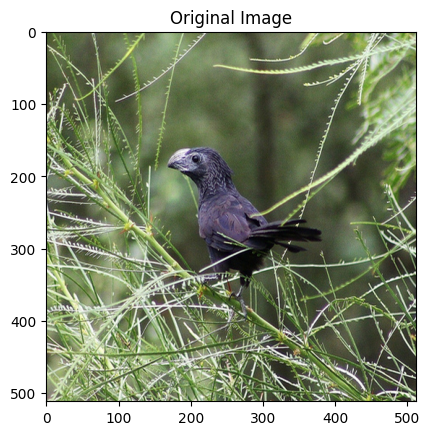

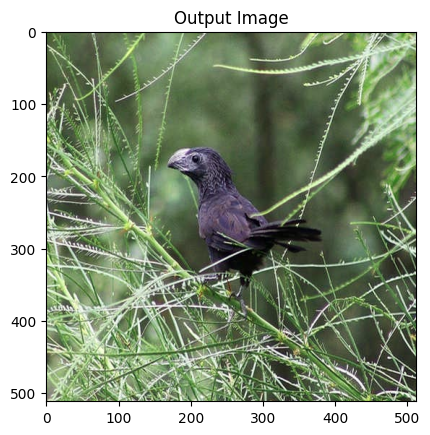

SSIM: 0.7285132328152057
PSNR: 28.232140507434863
MSE: 97.69364420572917
RMSE: 9.884009520722305
Compression Ratio: 4.914063281015696
BPP: 1.6280924479166667


In [15]:
filename = 'C1236.bmp'
path = 'caltech_colour/'

image = ColourJPEG(filename, path, 51)
image.compress()
image.save_data()
image.decode()
image.get_output_image()
image.evaluate()

view_image(image.originalImage, 'Original Image')
view_image(image.outputImage, 'Output Image')

print('SSIM:', image.ssim_value)
print('PSNR:', image.psnr_value)
print('MSE:', image.mse_value)
print('RMSE:', image.rmse_value)
print('Compression Ratio:', image.compression_ratio_value)
print('BPP:', image.bpp_value)

In [16]:
path_pil = 'outputs_pil/'
folder_pil = 'outputs_pil_'
filename = 'metrics.csv'

SSIM_PIL= []
PSNR_PIL = []
MSE_PIL = []
RMSE_PIL = []
CR_PIL = []
BPP_PIL = []

for i in range(1, 21):
    # Use f-string to format with leading zeros
    padded_number = f"{i:02}"
    file_path = path_pil + folder_pil + padded_number + '/'
    
    file = file_path + filename
    df = pd.read_csv(file)

    ssim_val = df['SSIM'].values
    psnr_val = df['PSNR'].values
    mse_val = df['MSE'].values
    rmse_val = df['RMSE'].values
    cr_val = df['Compression Ratio'].values
    bpp_val = df['Bits Per Pixel'].values

    SSIM_PIL.append(np.array(ssim_val))
    PSNR_PIL.append(np.array(psnr_val))
    MSE_PIL.append(np.array(mse_val))
    RMSE_PIL.append(np.array(rmse_val))
    CR_PIL.append(np.array(cr_val))
    BPP_PIL.append(np.array(bpp_val))
    print('Read file:', file)

Read file: outputs_pil/outputs_pil_01/metrics.csv
Read file: outputs_pil/outputs_pil_02/metrics.csv
Read file: outputs_pil/outputs_pil_03/metrics.csv
Read file: outputs_pil/outputs_pil_04/metrics.csv
Read file: outputs_pil/outputs_pil_05/metrics.csv
Read file: outputs_pil/outputs_pil_06/metrics.csv
Read file: outputs_pil/outputs_pil_07/metrics.csv
Read file: outputs_pil/outputs_pil_08/metrics.csv
Read file: outputs_pil/outputs_pil_09/metrics.csv
Read file: outputs_pil/outputs_pil_10/metrics.csv
Read file: outputs_pil/outputs_pil_11/metrics.csv
Read file: outputs_pil/outputs_pil_12/metrics.csv
Read file: outputs_pil/outputs_pil_13/metrics.csv
Read file: outputs_pil/outputs_pil_14/metrics.csv
Read file: outputs_pil/outputs_pil_15/metrics.csv
Read file: outputs_pil/outputs_pil_16/metrics.csv
Read file: outputs_pil/outputs_pil_17/metrics.csv
Read file: outputs_pil/outputs_pil_18/metrics.csv
Read file: outputs_pil/outputs_pil_19/metrics.csv
Read file: outputs_pil/outputs_pil_20/metrics.csv


In [17]:
path_cv2 = 'outputs_cv2/'
folder_cv2 = 'outputs_cv2_'
filename = 'metrics.csv'

SSIM_cv2= []
PSNR_cv2 = []
MSE_cv2 = []
RMSE_cv2 = []
CR_cv2 = []
BPP_cv2 = []

for i in range(1, 21):
    # Use f-string to format with leading zeros
    padded_number = f"{i:02}"
    file_path = path_cv2 + folder_cv2 + padded_number + '/'
    
    file = file_path + filename
    df = pd.read_csv(file)

    ssim_val = df['SSIM'].values
    psnr_val = df['PSNR'].values
    mse_val = df['MSE'].values
    rmse_val = df['RMSE'].values
    cr_val = df['Compression Ratio'].values
    bpp_val = df['Bits Per Pixel'].values

    SSIM_cv2.append(np.array(ssim_val))
    PSNR_cv2.append(np.array(psnr_val))
    MSE_cv2.append(np.array(mse_val))
    RMSE_cv2.append(np.array(rmse_val))
    CR_cv2.append(np.array(cr_val))
    BPP_cv2.append(np.array(bpp_val))
    print('Read file:', file)

Read file: outputs_cv2/outputs_cv2_01/metrics.csv
Read file: outputs_cv2/outputs_cv2_02/metrics.csv
Read file: outputs_cv2/outputs_cv2_03/metrics.csv
Read file: outputs_cv2/outputs_cv2_04/metrics.csv
Read file: outputs_cv2/outputs_cv2_05/metrics.csv
Read file: outputs_cv2/outputs_cv2_06/metrics.csv
Read file: outputs_cv2/outputs_cv2_07/metrics.csv
Read file: outputs_cv2/outputs_cv2_08/metrics.csv
Read file: outputs_cv2/outputs_cv2_09/metrics.csv
Read file: outputs_cv2/outputs_cv2_10/metrics.csv
Read file: outputs_cv2/outputs_cv2_11/metrics.csv
Read file: outputs_cv2/outputs_cv2_12/metrics.csv
Read file: outputs_cv2/outputs_cv2_13/metrics.csv
Read file: outputs_cv2/outputs_cv2_14/metrics.csv
Read file: outputs_cv2/outputs_cv2_15/metrics.csv
Read file: outputs_cv2/outputs_cv2_16/metrics.csv
Read file: outputs_cv2/outputs_cv2_17/metrics.csv
Read file: outputs_cv2/outputs_cv2_18/metrics.csv
Read file: outputs_cv2/outputs_cv2_19/metrics.csv
Read file: outputs_cv2/outputs_cv2_20/metrics.csv


In [18]:
path_matlab = 'outputs_matlab/metrics_matlab/metrics_'

SSIM_matlab= []
PSNR_matlab = []
MSE_matlab = []
RMSE_matlab = []
CR_matlab = []
BPP_matlab = []

for i in range(1, 21):
    file = path_matlab + str(i) + '.txt'
    df = pd.read_csv(file, sep='\t')

    ssim_val = df['SSIM'].values
    psnr_val = df['PSNR'].values
    mse_val = df['MSE'].values
    rmse_val = df['RMSE'].values
    cr_val = df['CompressionRatio'].values
    bpp_val = df['BPP'].values

    SSIM_matlab.append(np.array(ssim_val))
    PSNR_matlab.append(np.array(psnr_val))
    MSE_matlab.append(np.array(mse_val))
    RMSE_matlab.append(np.array(rmse_val))
    CR_matlab.append(np.array(cr_val))
    BPP_matlab.append(np.array(bpp_val))
    print('Read file:', file)

Read file: outputs_matlab/metrics_matlab/metrics_1.txt
Read file: outputs_matlab/metrics_matlab/metrics_2.txt
Read file: outputs_matlab/metrics_matlab/metrics_3.txt
Read file: outputs_matlab/metrics_matlab/metrics_4.txt
Read file: outputs_matlab/metrics_matlab/metrics_5.txt
Read file: outputs_matlab/metrics_matlab/metrics_6.txt
Read file: outputs_matlab/metrics_matlab/metrics_7.txt
Read file: outputs_matlab/metrics_matlab/metrics_8.txt
Read file: outputs_matlab/metrics_matlab/metrics_9.txt
Read file: outputs_matlab/metrics_matlab/metrics_10.txt
Read file: outputs_matlab/metrics_matlab/metrics_11.txt
Read file: outputs_matlab/metrics_matlab/metrics_12.txt
Read file: outputs_matlab/metrics_matlab/metrics_13.txt
Read file: outputs_matlab/metrics_matlab/metrics_14.txt
Read file: outputs_matlab/metrics_matlab/metrics_15.txt
Read file: outputs_matlab/metrics_matlab/metrics_16.txt
Read file: outputs_matlab/metrics_matlab/metrics_17.txt
Read file: outputs_matlab/metrics_matlab/metrics_18.txt
R

In [19]:
path = 'metrics/C00'

SSIM = []
PSNR = []
MSE = []
RMSE = []
CR = []
BPP = []

for i in range(1, 21):
    padded_number = f"{i:02}"
    file = path + padded_number + '.csv'
    df = pd.read_csv(file)

    ssim_val = df['SSIM'].values
    psnr_val = df['PSNR'].values
    mse_val = df['MSE'].values
    rmse_val = df['RMSE'].values
    cr_val = df['CR'].values
    bpp_val = df['BPP'].values

    SSIM.append(np.array(ssim_val))
    PSNR.append(np.array(psnr_val))
    MSE.append(np.array(mse_val))
    RMSE.append(np.array(rmse_val))
    CR.append(np.array(cr_val))
    BPP.append(np.array(bpp_val))
    print('Read file:', file)

Read file: metrics/C0001.csv
Read file: metrics/C0002.csv
Read file: metrics/C0003.csv
Read file: metrics/C0004.csv
Read file: metrics/C0005.csv
Read file: metrics/C0006.csv
Read file: metrics/C0007.csv
Read file: metrics/C0008.csv
Read file: metrics/C0009.csv
Read file: metrics/C0010.csv
Read file: metrics/C0011.csv
Read file: metrics/C0012.csv
Read file: metrics/C0013.csv
Read file: metrics/C0014.csv
Read file: metrics/C0015.csv
Read file: metrics/C0016.csv
Read file: metrics/C0017.csv
Read file: metrics/C0018.csv
Read file: metrics/C0019.csv
Read file: metrics/C0020.csv


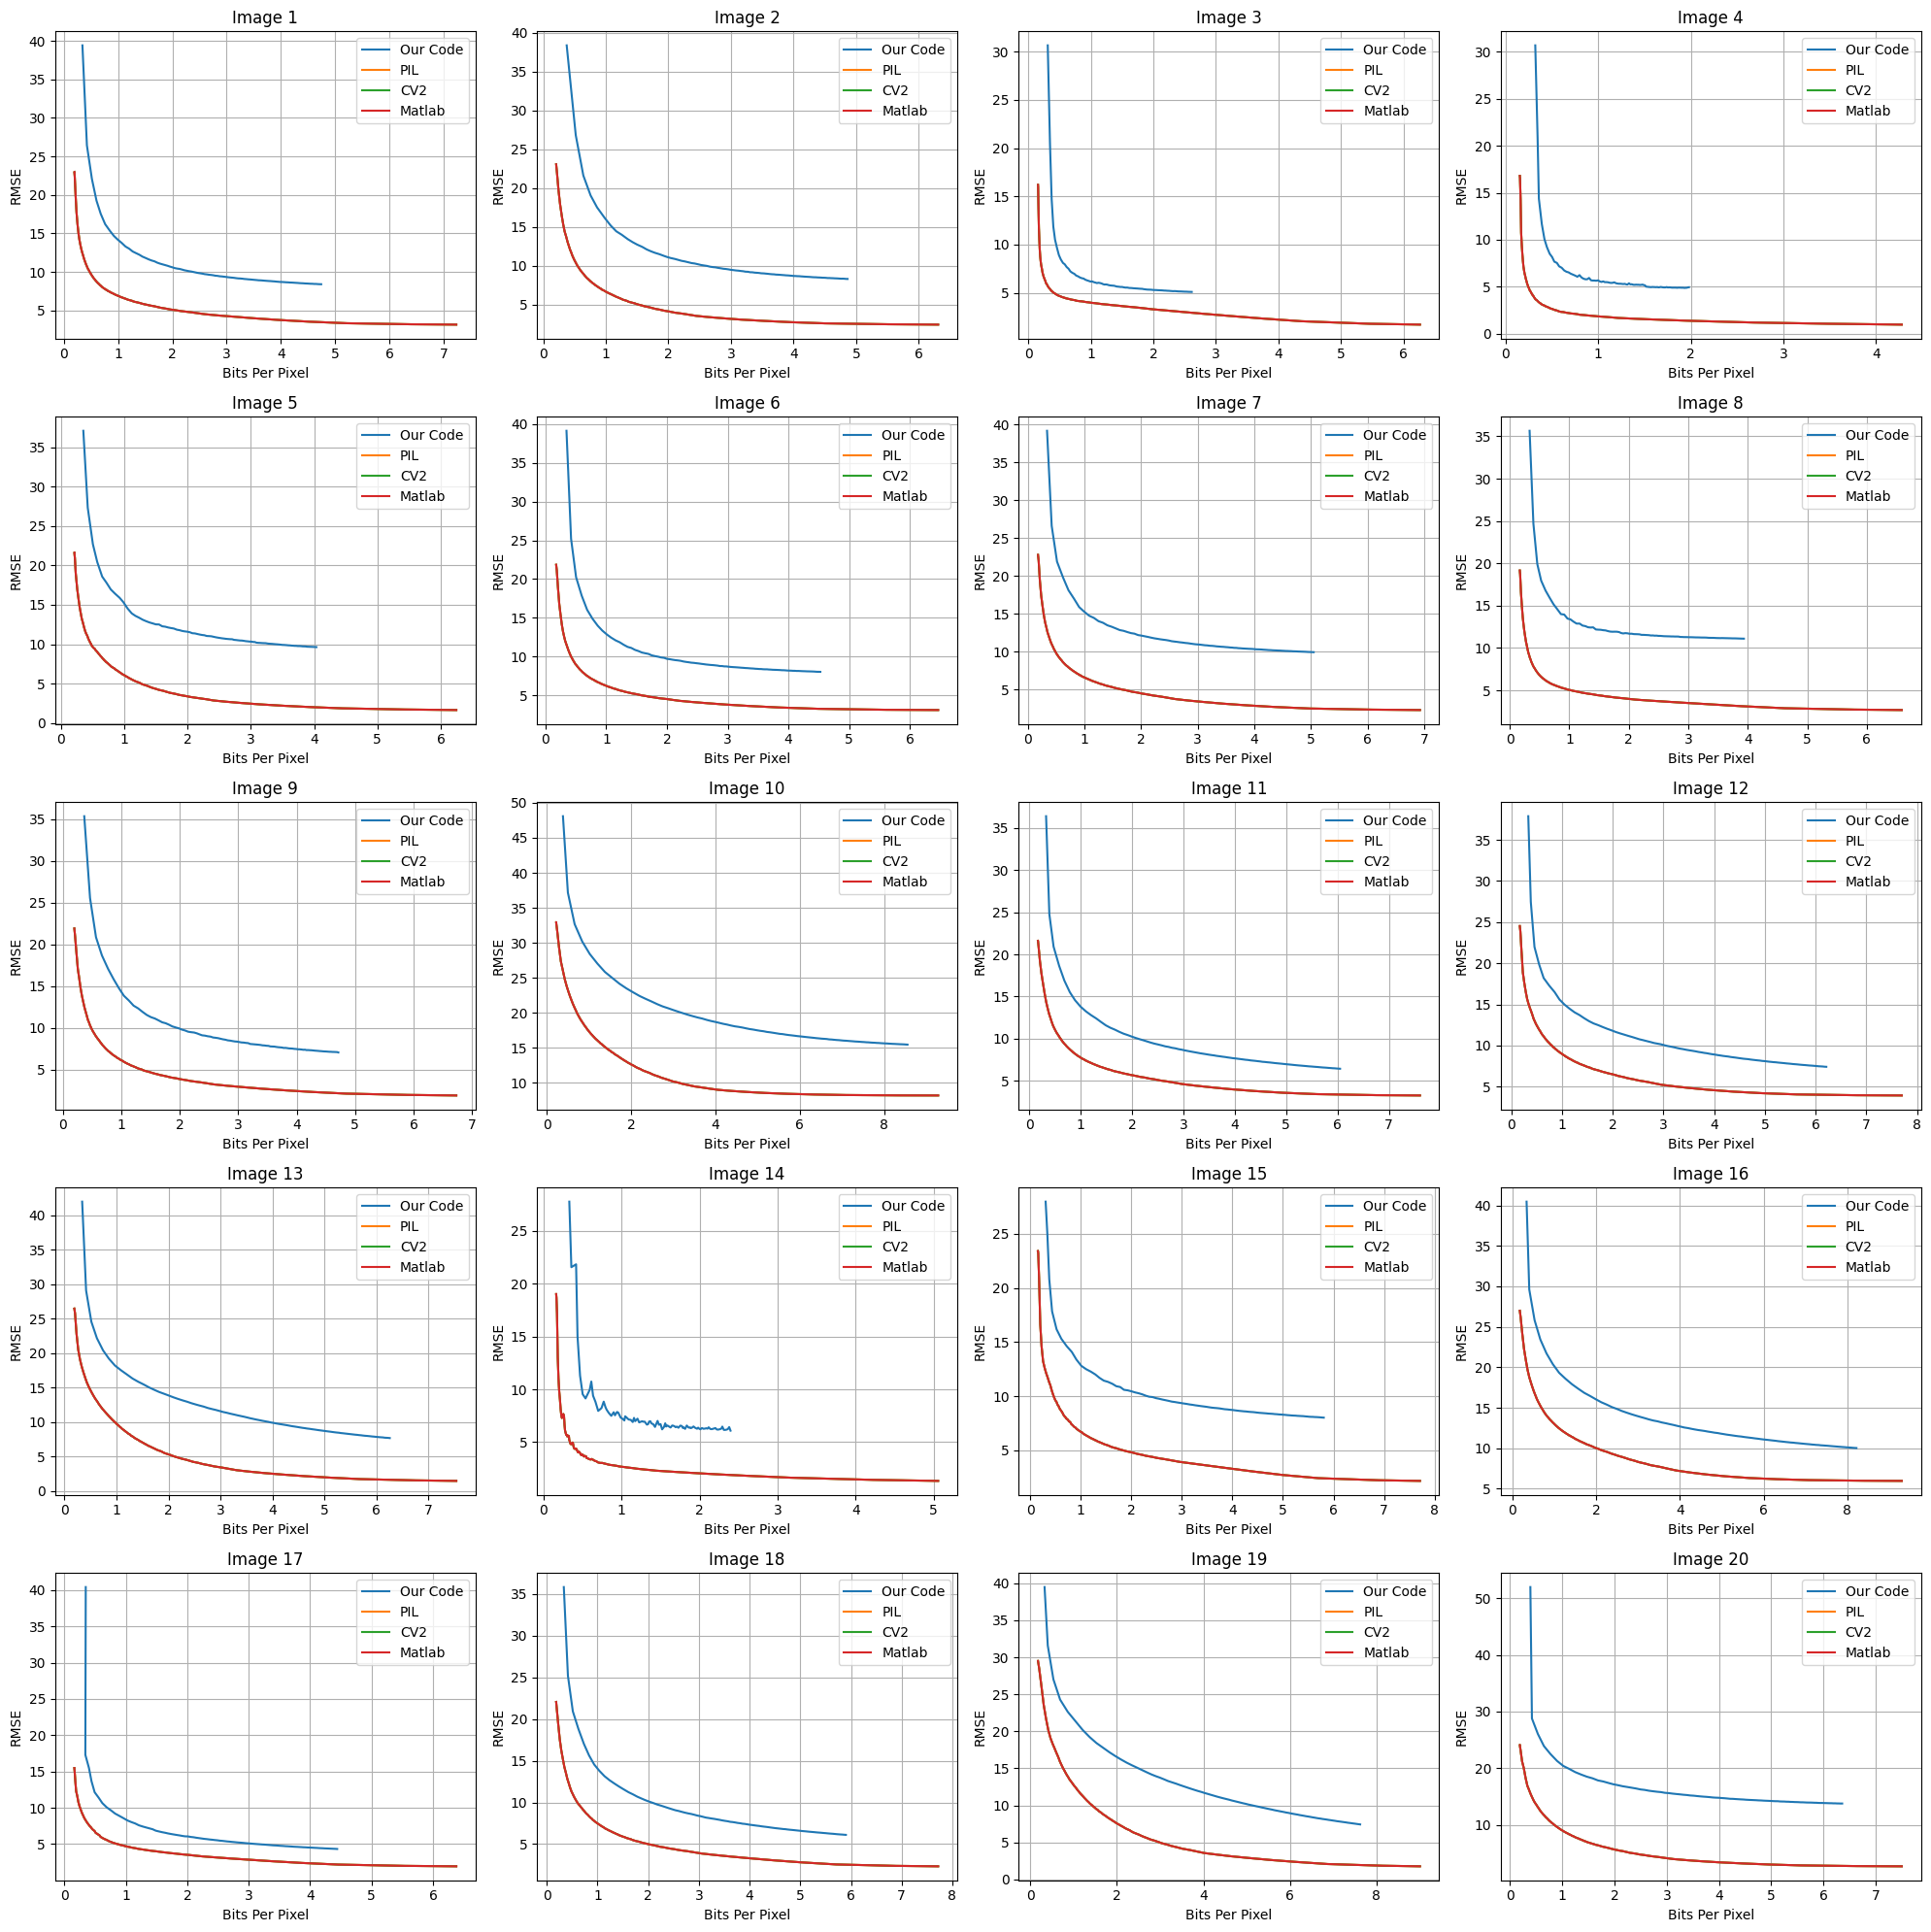

In [20]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))

for i in range(20):
    row = i // 4
    col = i % 4
    ax[row, col].plot(BPP[i]*3, RMSE[i], label='Our Code')
    ax[row, col].plot(BPP_PIL[i], RMSE_PIL[i], label='PIL')
    ax[row, col].plot(BPP_cv2[i], RMSE_cv2[i], label='CV2')
    ax[row, col].plot(BPP_matlab[i], RMSE_matlab[i], label='Matlab')

    ax[row, col].set_title('Image ' + str(i + 1))
    ax[row, col].set_xlabel('Bits Per Pixel')
    ax[row, col].set_ylabel('RMSE')
    ax[row, col].legend()
    ax[row, col].grid(True)

plt.tight_layout()
plt.show()

In [22]:
df_1499 = pd.read_csv('C1499.csv')
df_0489 = pd.read_csv('C0489.csv')

print(df_1499.columns)
print(df_0489.columns)

Index(['Quality Factor', 'SSIM', 'PSNR', 'MSE', 'RMSE', 'BPP',
       'Compression Ratio'],
      dtype='object')
Index(['Quality Factor', 'SSIM', 'PSNR', 'MSE', 'RMSE', 'BPP',
       'Compression Ratio'],
      dtype='object')


In [25]:
df_1499['RMSE'] = np.sqrt(df_1499['MSE'])
df_0489['RMSE'] = np.sqrt(df_0489['MSE'])

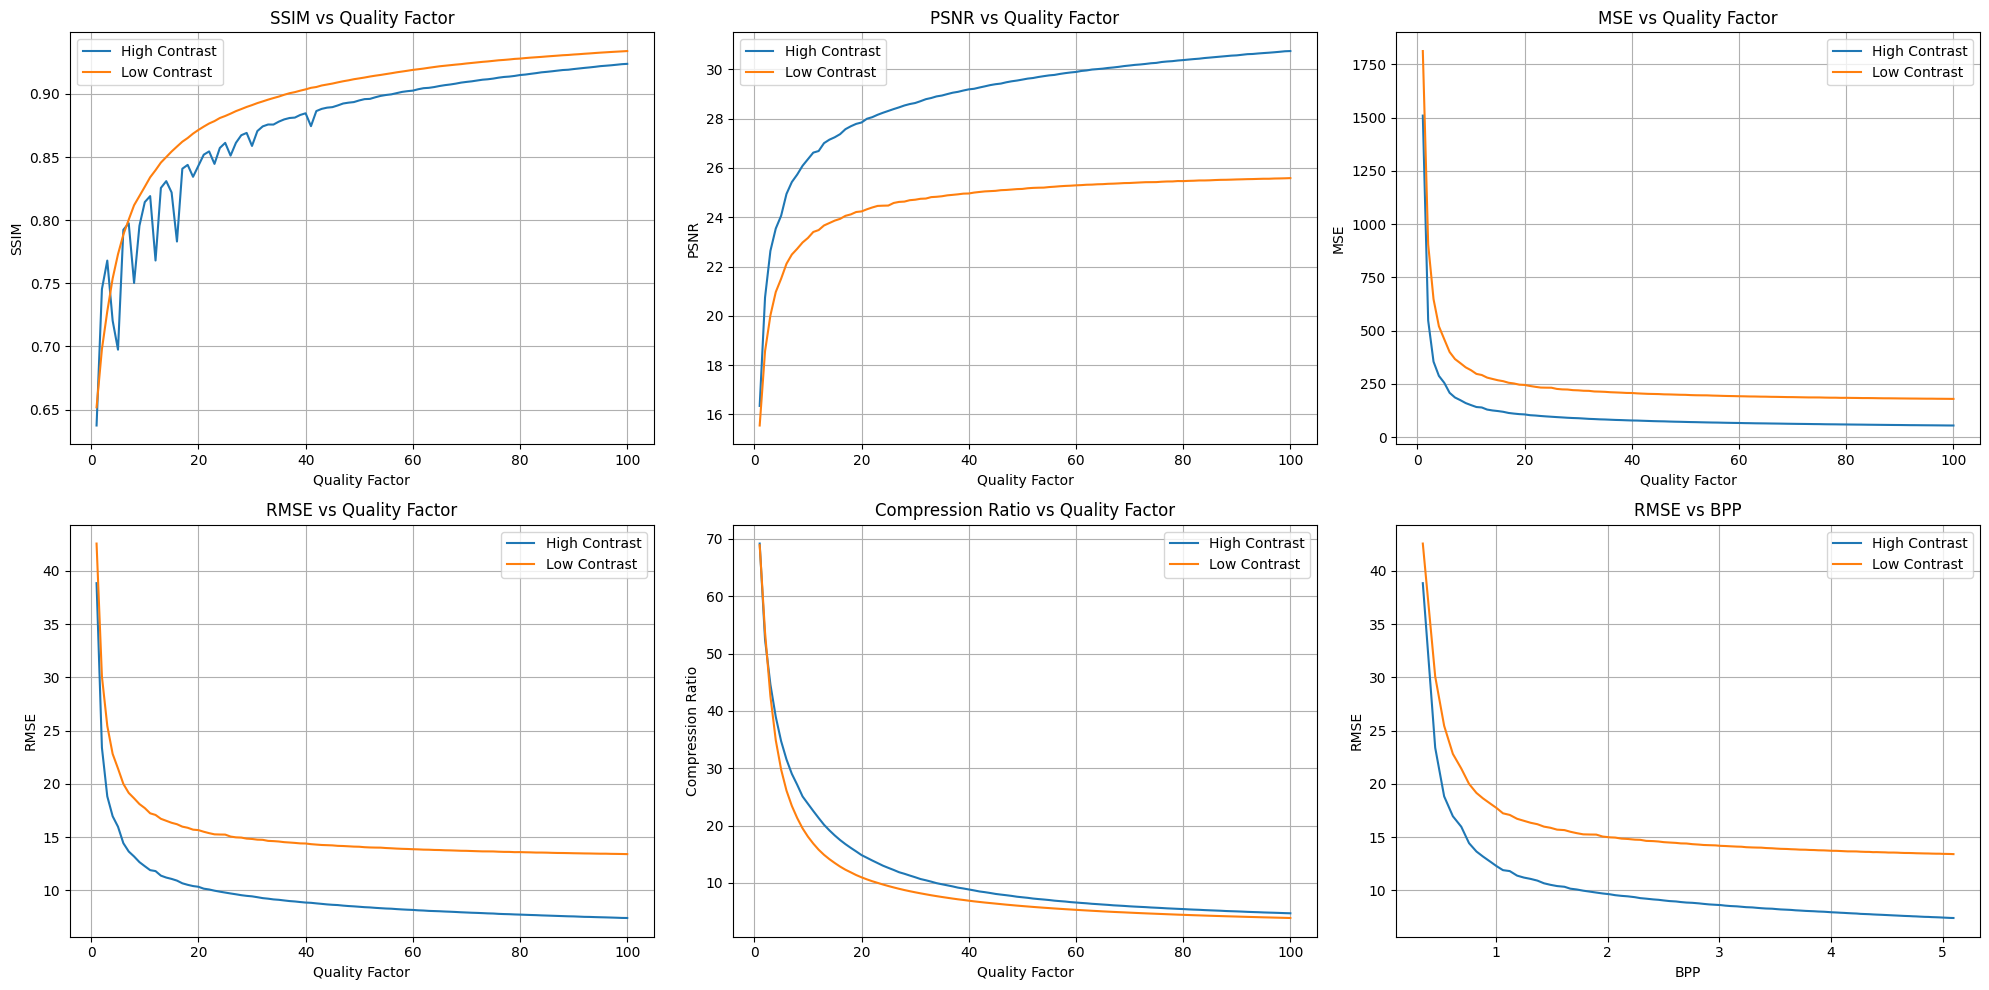

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))  

ax[0, 0].plot(df_1499['Quality Factor'], df_1499['SSIM'], label='High Contrast')
ax[0, 0].plot(df_1499['Quality Factor'], df_0489['SSIM'], label='Low Contrast')
ax[0, 0].set_title('SSIM vs Quality Factor')
ax[0, 0].set_xlabel('Quality Factor')
ax[0, 0].set_ylabel('SSIM')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(df_1499['Quality Factor'], df_1499['PSNR'], label='High Contrast')
ax[0, 1].plot(df_1499['Quality Factor'], df_0489['PSNR'], label='Low Contrast')
ax[0, 1].set_title('PSNR vs Quality Factor')
ax[0, 1].set_xlabel('Quality Factor')
ax[0, 1].set_ylabel('PSNR')
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[0, 2].plot(df_1499['Quality Factor'], df_1499['MSE'], label='High Contrast')
ax[0, 2].plot(df_1499['Quality Factor'], df_0489['MSE'], label='Low Contrast')
ax[0, 2].set_title('MSE vs Quality Factor')
ax[0, 2].set_xlabel('Quality Factor')
ax[0, 2].set_ylabel('MSE')
ax[0, 2].legend()
ax[0, 2].grid(True)

ax[1, 0].plot(df_1499['Quality Factor'], df_1499['RMSE'], label='High Contrast')
ax[1, 0].plot(df_1499['Quality Factor'], df_0489['RMSE'], label='Low Contrast')
ax[1, 0].set_title('RMSE vs Quality Factor')
ax[1, 0].set_xlabel('Quality Factor')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(df_1499['Quality Factor'], df_1499['Compression Ratio'], label='High Contrast')
ax[1, 1].plot(df_1499['Quality Factor'], df_0489['Compression Ratio'], label='Low Contrast')
ax[1, 1].set_title('Compression Ratio vs Quality Factor')
ax[1, 1].set_xlabel('Quality Factor')
ax[1, 1].set_ylabel('Compression Ratio')
ax[1, 1].legend()
ax[1, 1].grid(True)

ax[1, 2].plot(df_1499['BPP'], df_1499['RMSE'], label='High Contrast')
ax[1, 2].plot(df_1499['BPP'], df_0489['RMSE'], label='Low Contrast')
ax[1, 2].set_title('RMSE vs BPP')
ax[1, 2].set_xlabel('BPP')
ax[1, 2].set_ylabel('RMSE')
ax[1, 2].legend()
ax[1, 2].grid(True)

plt.tight_layout()
plt.show()

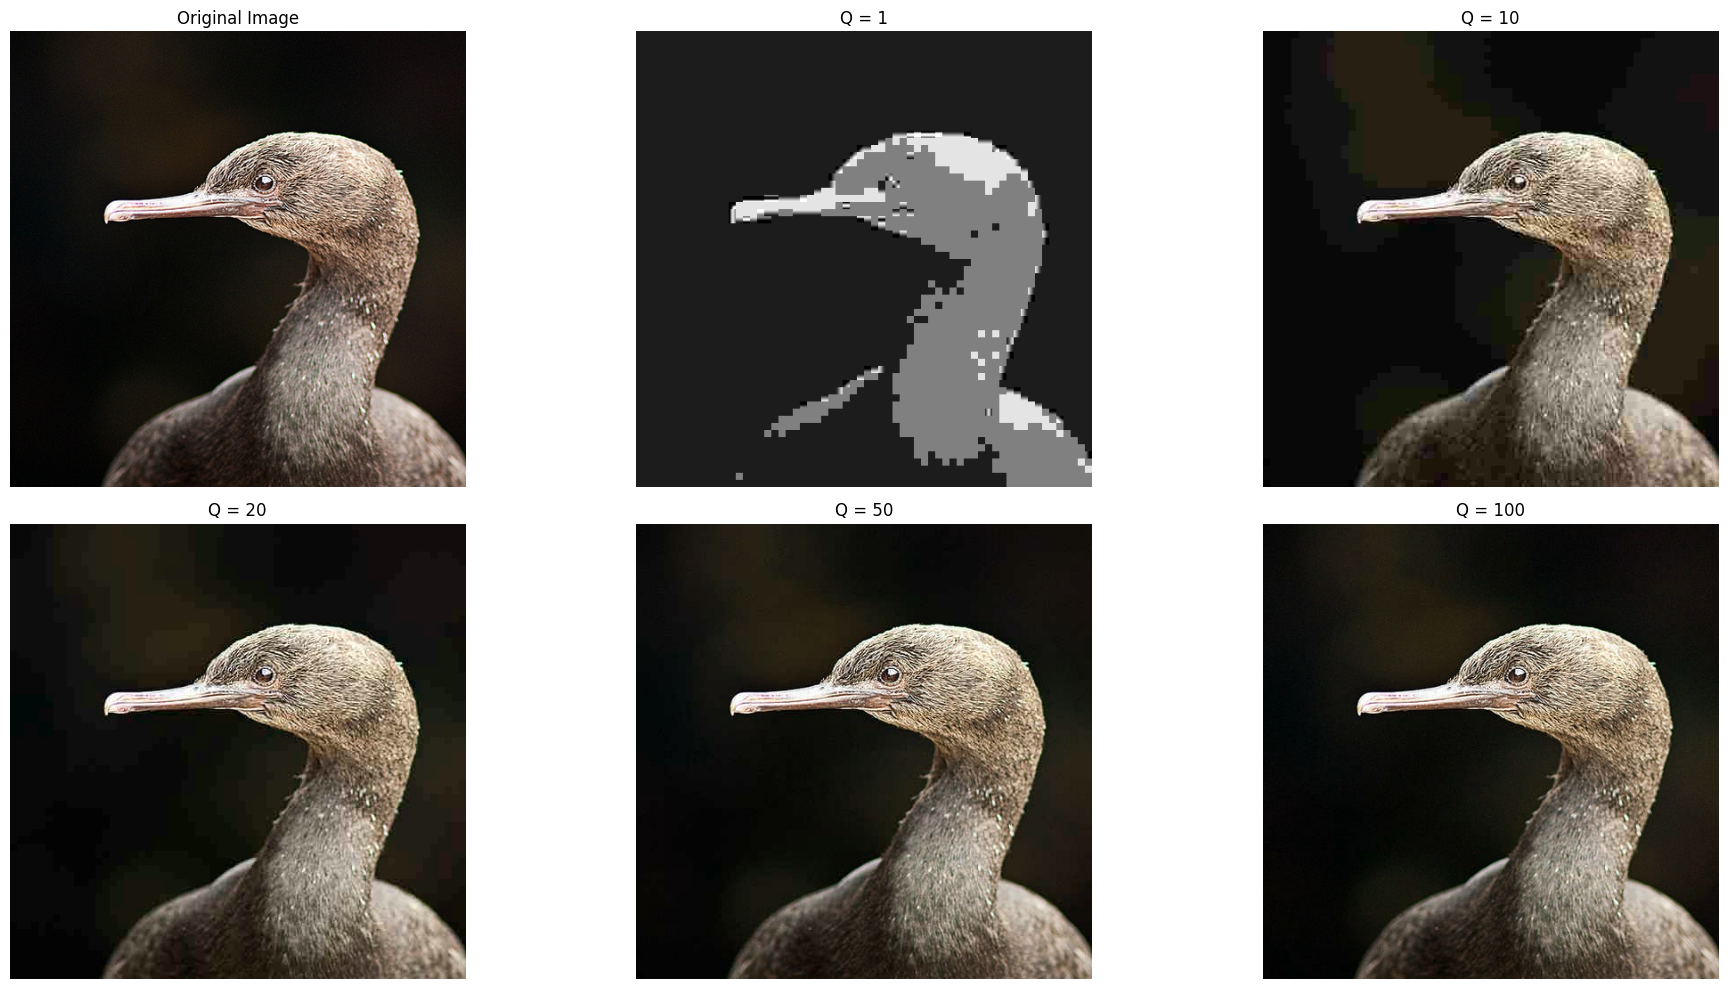

In [33]:
Q = [1, 10, 20, 50, 100]

filename = 'C0423.bmp'
path = 'caltech_colour/'

compressed_images = []
original_image = cv2.imread(path + filename)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

for q in Q:
    image = ColourJPEG(filename, path, q)
    image.compress()
    image.save_data()
    image.decode()
    image.get_output_image()
    image.evaluate()
    compressed_images.append(image)

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

ax[0, 0].imshow(original_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(compressed_images[0].outputImage, cmap='gray')
ax[0, 1].set_title('Q = 1')
ax[0, 1].axis('off')

ax[0, 2].imshow(compressed_images[1].outputImage, cmap='gray')
ax[0, 2].set_title('Q = 10')
ax[0, 2].axis('off')

ax[1, 0].imshow(compressed_images[2].outputImage, cmap='gray')
ax[1, 0].set_title('Q = 20')
ax[1, 0].axis('off')

ax[1, 1].imshow(compressed_images[3].outputImage, cmap='gray')
ax[1, 1].set_title('Q = 50')
ax[1, 1].axis('off')

ax[1, 2].imshow(compressed_images[4].outputImage, cmap='gray')
ax[1, 2].set_title('Q = 100')
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [34]:
filename = 'C0001.bmp'
path = 'caltech_colour/'

Q = np.linspace(1, 100, 100, dtype=int)

SSIM = []
PSNR = []
MSE = []
RMSE = []
CR = []
BPP = []

for q in Q:
    image = ColourJPEG(filename, path, q)
    image.compress()
    image.save_data()
    image.decode()
    image.get_output_image()
    image.evaluate()

    SSIM.append(image.ssim_value)
    PSNR.append(image.psnr_value)
    MSE.append(image.mse_value)
    RMSE.append(image.rmse_value)
    CR.append(image.compression_ratio_value)
    BPP.append(image.bpp_value)

In [37]:
BPP = [b * 3 for b in BPP]

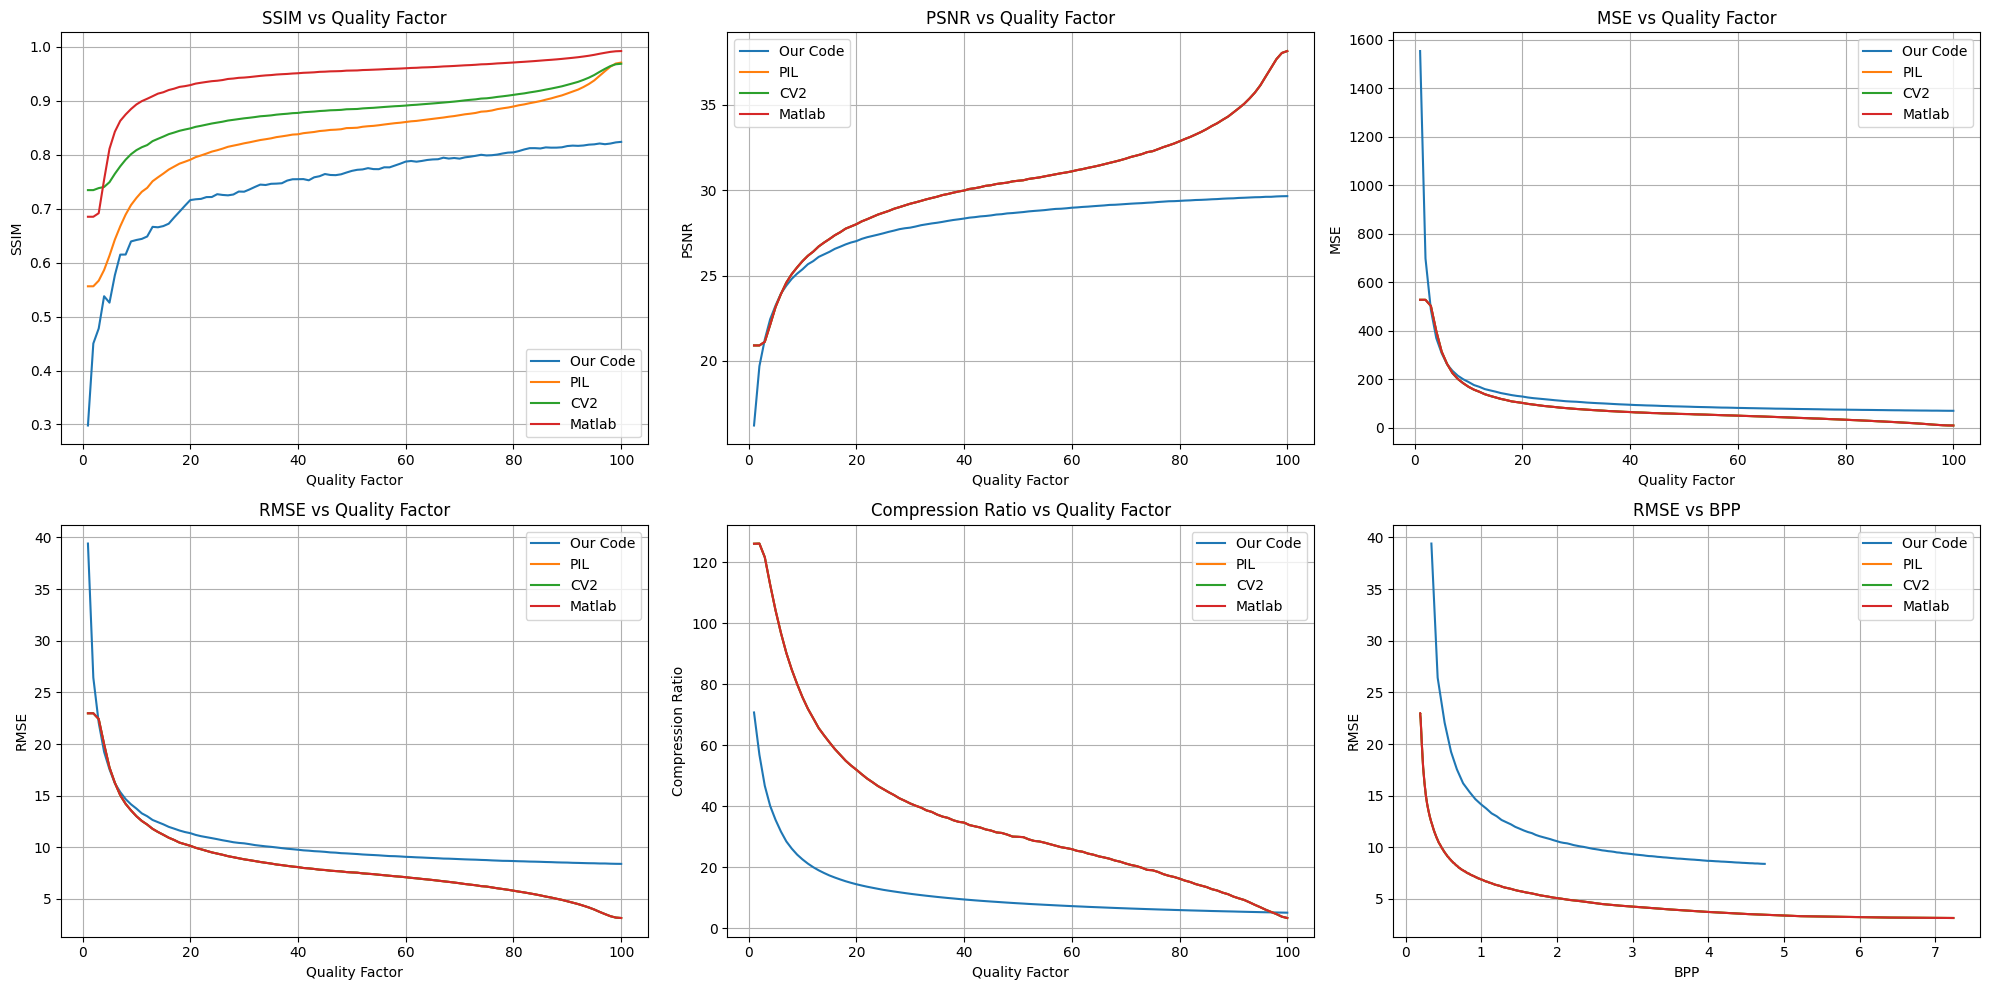

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

ax[0, 0].plot(Q, SSIM, label='Our Code')
ax[0, 0].plot(Q, SSIM_PIL[0], label='PIL')
ax[0, 0].plot(Q, SSIM_cv2[0], label='CV2')
ax[0, 0].plot(Q, SSIM_matlab[0], label='Matlab')
ax[0, 0].set_title('SSIM vs Quality Factor')
ax[0, 0].set_xlabel('Quality Factor')
ax[0, 0].set_ylabel('SSIM')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(Q, PSNR, label='Our Code')
ax[0, 1].plot(Q, PSNR_PIL[0], label='PIL')
ax[0, 1].plot(Q, PSNR_cv2[0], label='CV2')
ax[0, 1].plot(Q, PSNR_matlab[0], label='Matlab')
ax[0, 1].set_title('PSNR vs Quality Factor')
ax[0, 1].set_xlabel('Quality Factor')
ax[0, 1].set_ylabel('PSNR')
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[0, 2].plot(Q, MSE, label='Our Code')
ax[0, 2].plot(Q, MSE_PIL[0], label='PIL')
ax[0, 2].plot(Q, MSE_cv2[0], label='CV2')
ax[0, 2].plot(Q, MSE_matlab[0], label='Matlab')
ax[0, 2].set_title('MSE vs Quality Factor')
ax[0, 2].set_xlabel('Quality Factor')
ax[0, 2].set_ylabel('MSE')
ax[0, 2].legend()
ax[0, 2].grid(True)

ax[1, 0].plot(Q, RMSE, label='Our Code')
ax[1, 0].plot(Q, RMSE_PIL[0], label='PIL')
ax[1, 0].plot(Q, RMSE_cv2[0], label='CV2')
ax[1, 0].plot(Q, RMSE_matlab[0], label='Matlab')
ax[1, 0].set_title('RMSE vs Quality Factor')
ax[1, 0].set_xlabel('Quality Factor')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(Q, CR, label='Our Code')
ax[1, 1].plot(Q, CR_PIL[0], label='PIL')
ax[1, 1].plot(Q, CR_cv2[0], label='CV2')
ax[1, 1].plot(Q, CR_matlab[0], label='Matlab')
ax[1, 1].set_title('Compression Ratio vs Quality Factor')
ax[1, 1].set_xlabel('Quality Factor')
ax[1, 1].set_ylabel('Compression Ratio')
ax[1, 1].legend()
ax[1, 1].grid(True)

ax[1, 2].plot(BPP, RMSE, label='Our Code')
ax[1, 2].plot(BPP_PIL[0], RMSE_PIL[0], label='PIL')
ax[1, 2].plot(BPP_cv2[0], RMSE_cv2[0], label='CV2')
ax[1, 2].plot(BPP_matlab[0], RMSE_matlab[0], label='Matlab')
ax[1, 2].set_title('RMSE vs BPP')
ax[1, 2].set_xlabel('BPP')
ax[1, 2].set_ylabel('RMSE')
ax[1, 2].legend()
ax[1, 2].grid(True)

plt.tight_layout()
plt.show()